**NOMS I COGNOMS:**

**GRUP DE LABORATORI:**

# Anàlisi exploratòria de dades i preprocessament 

L'**anàlisi exploratòria de dades** és el tractament estadístic al qual se sotmeten les mostres recollides durant un procés de recerca en qualsevol camp científic. 
Per a major rapidesa i precisió, tot el procés sol realitzar-se per mitjans informàtics, amb aplicacions específiques per al tractament estadístic.

### Aplicació a la Mineria de Dades

A la **mineria de dades**, si bé no és obligatori, és una bona pràctica analitzar les dades amb què treballarem per tal d'observar-ne les característiques principals per tal de tenir una idea de l'estructura del conjunt de dades, identificar la variable objectiu i possibles tècniques de modelatge.

**Procés bàsic**
- *Transformar les dades*: Ens serveix per saber què fer front a valors nuls, faltants o dades atípiques. A més destablir si hi ha necessitat de reduir la dimensionalitat de dades.
- *Visualitzar*: Utilitzar alguna eina per fer una representació gràfica de les dades, per exemple, R, Jupyter notebook, Google Colab, etc.
- *Analitzar i interpretar*: Analitzar i interpretar les dades a través de diferents visualitzacions.
- *Documentar*: Documentar totes les gràfiques i estadístiques generades.

Aquest procés ens és útil també en revisar la descripció de les dades per comprendre què significa cada característica.

Hi ha diverses activitats en fer una anàlisi exploratòria de dades però quant a la mineria de dades els punts clau que s'han de realitzar són:

- Descripció de l'estructura de les dades.
- Identificació de dades mancants.# ¿Com ha afectat la covid a l'ús dels taxis a Nova York? 
- Detecció de valors atípics.
- Identificació de relacions entre parells variables.

Si realitzem correctament els passos ens facilitarem la manera d'abordar aquestes dades sense deixar de banda l'objectiu o el propòsit per al qual les necessitem.

L'**objectiu d'aquesta pràctica** és aprendre com fer una explicació de dades. En aquest cas utilitzarem les dades dels **taxis grocs de la ciutat de Nova York**.

En finalitzar el notebook, haureu de ser capaços de respondre la pregunta següent:


## ¿Com ha afectat la covid a l'ús dels taxis a Nova York? 

Algunes de les preguntes que ens farem al llarg del notebook són:
- Com ha canviat la covid l'ús dels taxis a NYC?
- Quina distribució d'encàrrecs segueixen els taxis i quina distància / durada tenen?
- Quines són les zones on m'és / menys taxis s'agafen? I a on més va la gent?
- Quins horaris són els més usuals?
- Quins dies de la setmana i del mes s'utilitzen més? Possibles motius?

**Instal·lació i importació de les llibreries necessàries**

In [1]:
! pip install pyarrow
! pip install pyshp
! pip install shapely
! pip install descartes

  Using cached pyarrow-9.0.0-cp38-cp38-win_amd64.whl (19.6 MB)
  Using cached pyshp-2.3.1-py2.py3-none-any.whl (46 kB)
  Using cached Shapely-1.8.4-cp38-cp38-win_amd64.whl (1.3 MB)
  Using cached descartes-1.1.0-py3-none-any.whl (5.8 kB)


In [1]:
# Importació de les llibreries
import pandas as pd
import numpy as np
import urllib.request
import zipfile
import os
from tqdm.notebook import tqdm
import pyarrow.parquet as pq

In [2]:
import shapefile
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Variables globals
YEARS = [2019, 2020, 2021]

Primer de tot cal descarregar les dades:

https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page

In [4]:
# Download the Trip Record Data
for year in tqdm(YEARS):
    if not os.path.exists(f'data/{year}'):
        os.makedirs(f'data/{year}', exist_ok=True)
        for month in tqdm(range(1, 13)): 
            urllib.request.urlretrieve(f'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_{year}-{month:02d}.parquet', f'data/{year}/{month:02d}.parquet')

## 01. Neteja de dades

Per tal de tenir unes dades netes i útils, cal eliminar totes aquelles files que continguin informació corrupta:
- La recollida és després que la finalització del trajecte.
- Les dades s'importen per mes i any. Les dates són correctes?
- Viatges amb 0 passatges?
- Viatges molts llargs o molt curts?
- Pagaments negatius.

**Data Dictionary**

De totes les columnes que tenen les dades, només calen les següents:

- *tpep_pickup_datetime*: The date and time when the meter was engaged.
- *tpep_dropoff_datetime*: The date and time when the meter was disengaged. 
- *Passenger_count*: The number of passengers in the vehicle. (This is a driver-entered value)
- *Trip_distance*: The elapsed trip distance in miles reported by the taximeter.
- *PULocationID*: TLC Taxi Zone in which the taximeter was engaged
- *DOLocationID*: TLC Taxi Zone in which the taximeter was disengaged
- *Payment_type*: A numeric code signifying how the passenger paid for the trip. 
    - 1= Credit card
    - 2= Cash
    - 3= No charge
    - 4= Dispute
    - 5= Unknown
    - 6= Voided trip
- *Fare_amount*: The time-and-distance fare calculated by the meter.
- *Total_amount*: The total amount charged to passengers. Does not include cash tips.

**Observacions:**

- Per agilitzar els càlculs i reduir el temps de còmput, feu un sampleig uniforme de les dades.
- Datatime columns són to_datetime series (ajuda per buscar les funcions)

In [5]:
'''
Preguntes
    location id surten repetides
    
    Fer els heatmap per anys
    A l'ex del heatmap surten canviats d'ordre. Quin seguim?
    Com eliminar outliers?
    Visualitzar en anys diferents el passenger count?
    La forma del p_count correcta? 
    Què és un viatge massa curt o llarg?
    Quan usar fare amount o total amount
    Si hi ha un viatge que comença un any i acaba un altre, en quin any el considerem?
'''

"\nPreguntes\n    Visualitzar en anys diferents el passenger count?\n    Com eliminar outliers?\n    Per què passa les columnes de pickup i dropoff?\n    A l'ex del heatmap surten canviats d'ordre. Quin seguim?\n    Limit passengers_taxi\n    location id surten repetides\n    \n    La forma del p_count correcta? \n    Què és un viatge massa curt o llarg?\n    Quan usar fare amount o total amount\n    S'ha de mirar que el lloc de pickup i dropoff siguin vàlids segons les zones dels taxis de NY?\n    Si hi ha un viatge que comença un any i acaba un altre, en quin any el considerem?\n"

In [189]:
def load_table(year, month):
    """
    Funció que llegeix les dades descarregades i les converteix a un DataFrame
    """
    return pq.read_table(f'data/{year}/{str(month).zfill(2)}.parquet').to_pandas()

In [190]:
ex = load_table(2019, 12)

In [191]:
required_data = ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'total_amount']

def clean_data(data, year, month, sampling = 1000):
    """
    Funció que neteja les dades per un mes donat. Sampling agafa 1/sampling de les dades
    """
    # AQUÍ EL TEU CODI
    data = data[::sampling]
    uncorrupted = (data['passenger_count'] > 0) &  (data['passenger_count'] < 8) & (data['trip_distance'] > 0) & \
    (data['total_amount'] > 0) & (data['tpep_pickup_datetime'] < data['tpep_dropoff_datetime']) & \
    (data['tpep_pickup_datetime'].dt.month == month) & (data['tpep_pickup_datetime'].dt.year == year) & \
    (data['tpep_dropoff_datetime'].dt.month == month) & (data['tpep_dropoff_datetime'].dt.year == year) & \
    (data['PULocationID'] >= 1) & (data['PULocationID'] <= 263) & (data['DOLocationID'] >= 1) & (data['DOLocationID'] <= 263)
    #les locationID han d'anar de 1 fins a 263. Treiem les incorrectes
    
    data= data[required_data]
    data = data.loc[uncorrupted]
    return data

In [192]:
ex = clean_data(ex, 2019, 12)

In [193]:
ex[ex['total_amount'] == ex['total_amount'].max()]
#que el que més pagui sigui per una distància tan petita està malament no???

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount
4342000,2019-12-18 16:10:08,2019-12-18 17:03:46,4.0,12.97,125,1,1,63.0,137.63


In [194]:
ex['trip_distance'].max()

33.13

A la funció *post_processing* podeu afegir tota aquesta informació que necessiteu sobre les dades per tal de dur a terme l'exploració necessària.

In [290]:
def post_processing(data):
    """
    Funció on implementar qualsevol tipus de postprocessament necessari.
    """
    # AQUÍ EL TEU CODI
    data['year'] = data['tpep_dropoff_datetime'].dt.year
    
    data['passenger_count'] = data['passenger_count'].astype('int')
    
    data['pickup_hour'] = data['tpep_pickup_datetime'].dt.hour
    data['dropoff_hour'] = data['tpep_dropoff_datetime'].dt.hour
    
    data['pickup_day'] = data['tpep_pickup_datetime'].dt.weekday
    data['dropoff_day'] = data['tpep_dropoff_datetime'].dt.weekday
    
    data['pickup_week'] = data['tpep_pickup_datetime'].dt.isocalendar().week
    data['dropoff_week'] = data['tpep_dropoff_datetime'].dt.isocalendar().week
    
    data['pickup_month'] = data['tpep_pickup_datetime'].dt.month
    data['dropoff_month'] = data['tpep_dropoff_datetime'].dt.month
    
    data['trip_duration'] = ((data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime']).dt.total_seconds())/3600
    data['trip_distance'] = 1.6*data['trip_distance']   #convert miles to km
    
    data['pickup_dayofyear'] = data['tpep_pickup_datetime'].dt.dayofyear
    
    data['mean_speed'] = data['trip_distance']/data['trip_duration']
    
    #eliminem els outliers
    '''inliers = (data['trip_duration'] > np.percentile(data['trip_duration'],1)) & \
    (data['trip_duration'] < np.percentile(data['trip_duration'],99)) & \
    (data['trip_distance'] > np.percentile(data['trip_distance'],1)) & \
    (data['trip_distance'] < np.percentile(data['trip_distance'],99))'''
    
    #data = data.loc[inliers]

    return data

Crea un nou dataset que contingui tota la informació dels anys: 2019, 2020, 2021.

Recordeu que per tal de reduir la memòria necessària, podeu agafar un subsample de dades.

In [293]:
df = pd.concat([clean_data(load_table(year, month), year, month) for year in tqdm(YEARS) for month in tqdm(range(1, 13), leave = False)])

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [294]:
df = post_processing(df)
df.shape

(131376, 21)

In [298]:
df.iloc[df['mean_speed'].argmax()]

tpep_pickup_datetime     2021-11-11 15:43:44
tpep_dropoff_datetime    2021-11-11 15:43:45
passenger_count                            2
trip_distance                          7.424
PULocationID                             234
DOLocationID                              75
payment_type                               2
fare_amount                             30.0
total_amount                            33.3
year                                    2021
pickup_hour                               15
dropoff_hour                              15
pickup_day                                 3
dropoff_day                                3
pickup_week                               45
dropoff_week                              45
pickup_month                              11
dropoff_month                             11
trip_duration                       0.000278
pickup_dayofyear                         315
mean_speed                           26726.4
Name: 1198000, dtype: object

In [198]:
df.head(10)

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount,year,...,dropoff_hour,pickup_day,dropoff_day,pickup_week,dropoff_week,pickup_month,dropoff_month,trip_duration,pickup_dayofyear,mean_speed
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1,2.400,151,239,1,7.0,9.95,2019,...,0,1,1,1,1,1,1,0.111111,1,21.600000
1000,2019-01-01 00:53:09,2019-01-01 01:01:16,1,3.056,148,137,2,8.5,9.80,2019,...,1,1,1,1,1,1,1,0.135278,1,22.590554
3000,2019-01-01 00:54:46,2019-01-01 01:03:13,1,2.240,249,164,1,7.5,11.40,2019,...,1,1,1,1,1,1,1,0.140833,1,15.905325
4000,2019-01-01 00:09:29,2019-01-01 00:12:29,2,1.072,162,137,2,4.0,5.30,2019,...,0,1,1,1,1,1,1,0.050000,1,21.440000
5000,2019-01-01 00:29:00,2019-01-01 00:46:19,1,4.336,161,262,1,13.5,17.76,2019,...,0,1,1,1,1,1,1,0.288611,1,15.023677
6000,2019-01-01 00:16:51,2019-01-01 00:33:46,1,11.360,144,82,2,22.5,23.80,2019,...,0,1,1,1,1,1,1,0.281944,1,40.291626
7000,2019-01-01 00:40:11,2019-01-01 00:45:02,5,1.792,43,237,1,6.0,8.76,2019,...,0,1,1,1,1,1,1,0.080833,1,22.169072
8000,2019-01-01 00:41:49,2019-01-01 00:47:09,1,2.112,74,263,2,6.0,7.30,2019,...,0,1,1,1,1,1,1,0.088889,1,23.760000
9000,2019-01-01 00:49:25,2019-01-01 01:16:02,1,8.576,249,262,1,21.0,26.76,2019,...,1,1,1,1,1,1,1,0.443611,1,19.332248
10000,2019-01-01 00:24:57,2019-01-01 00:30:03,1,0.704,113,234,2,5.0,6.30,2019,...,0,1,1,1,1,1,1,0.085000,1,8.282353


In [199]:
df.shape

(126592, 21)

In [205]:
df['trip_duration'].max()

0.995

In [200]:
print(df['trip_distance'].min(), df['trip_distance'].max())

0.496 30.384


In [201]:
print(np.percentile(df['trip_distance'],99),np.percentile(df['trip_distance'],1)) #potser podriem treure aquestes dades....

27.680000000000003 0.6400000000000001


In [202]:
print((df['total_amount']-df['fare_amount']).max())

74.63


## 02. Visualitzacions per anys

### Número total sobre quantitat de viatges

Podem respondre directament la pregunta: **¿Ha incrementat / disminuït la covid la quantitat de viatges fets amb taxis?**

Per respondre aquesta pregunta creu una figura de barres on es visualitzin la quantitat de viatges per any.

In [33]:
def bar_plot(df, column, xlabel, ylabel, title):
    """
    Funció que crea una figura de barres a partir del dataframe i la columna que conté la informació
    """
    # AQUÍ EL TEU CODI

    df[column].value_counts(sort=False).plot.bar(title=title, xlabel=xlabel, ylabel=ylabel, figsize=(15,7))
 

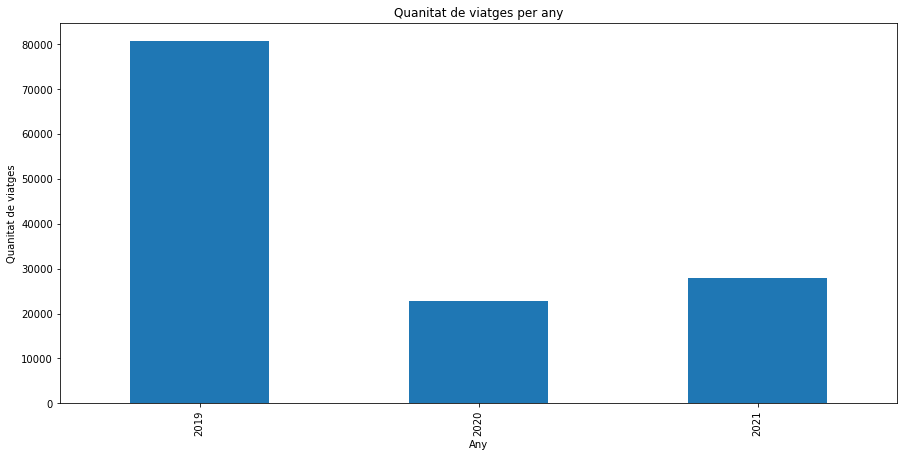

In [34]:
bar_plot(df, 'year', 'Any', 'Quanitat de viatges', 'Quanitat de viatges per any')

**Pregunta: És el comportament que esperàveu? Per què?**

> ANSWER

In [19]:
'''
Sí, l'any del confinament va baixar molt i quan a l'any següent millora una mica, però queda encara lluny del valor original.
'''

"\nSí, l'any del confinament va baixar molt i quan a l'any següent millora una mica, però queda encara lluny del valor original.\n"

Ara, visualitzarem **quants passatgers hi ha per taxi i per any**.

Crea una figura amb tres subfigures (una per any) on es pugui veure el recompte de passatgers per any.

Després repetiu el mateix gràfic visualitzant el % (utilitzeu el paràmetre *norm*).

In [20]:
def passengers_taxi_year(df, ylim, xlabel, ylabel, title, norm = False):
    """
    Funció que visualitza quants passatgers hi ha per taxi i per any
    """
    
    # AQUÍ EL TEU CODI
    fig, axs = plt.subplots(len(YEARS), 1, figsize=(15,17))
    fig.suptitle(title)
    
    for i in range(len(YEARS)):
        df.loc[df['year']==YEARS[i],['passenger_count']].value_counts(sort=False, normalize=norm).plot.bar(title=str(YEARS[i]), ax=axs[i])
        axs[i].set(xlabel=xlabel, ylabel=ylabel, ylim=ylim)


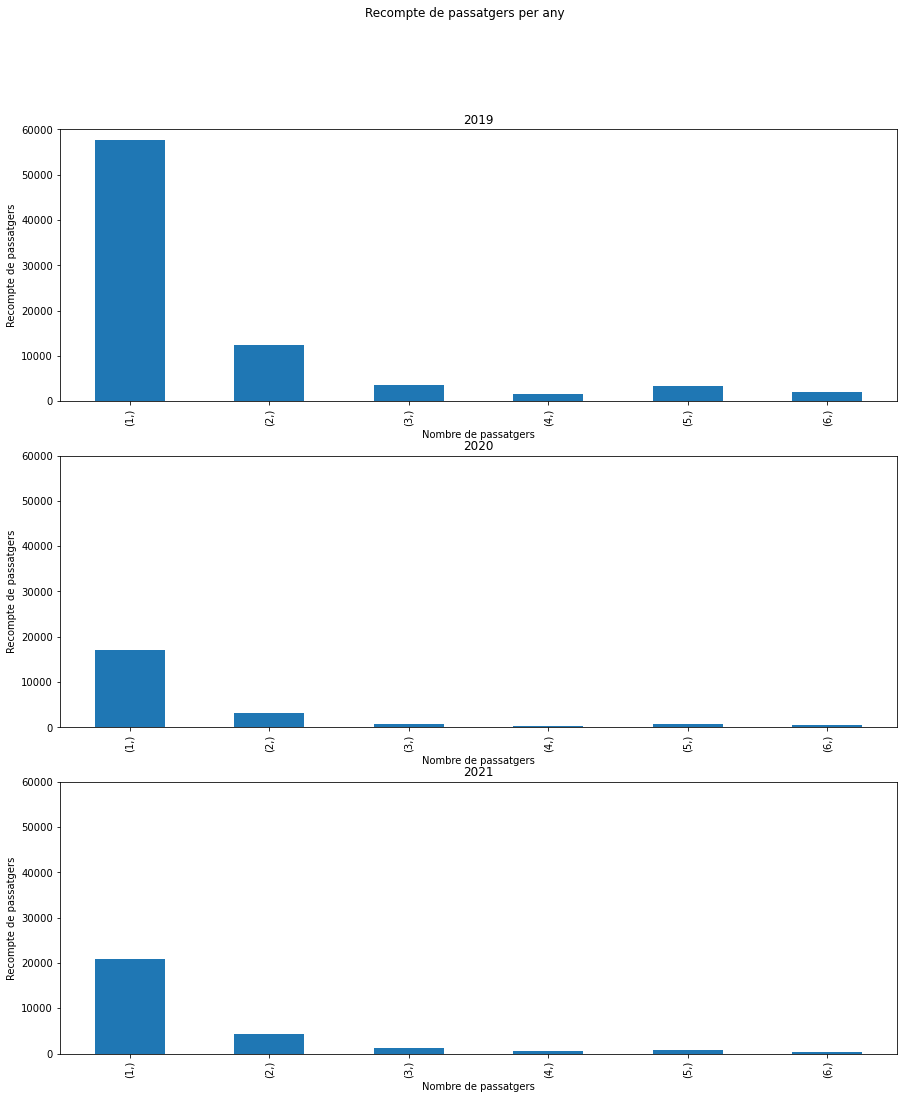

In [21]:
passengers_taxi_year(df, (0, 60000), 'Nombre de passatgers', 'Recompte de passatgers', 'Recompte de passatgers per any')

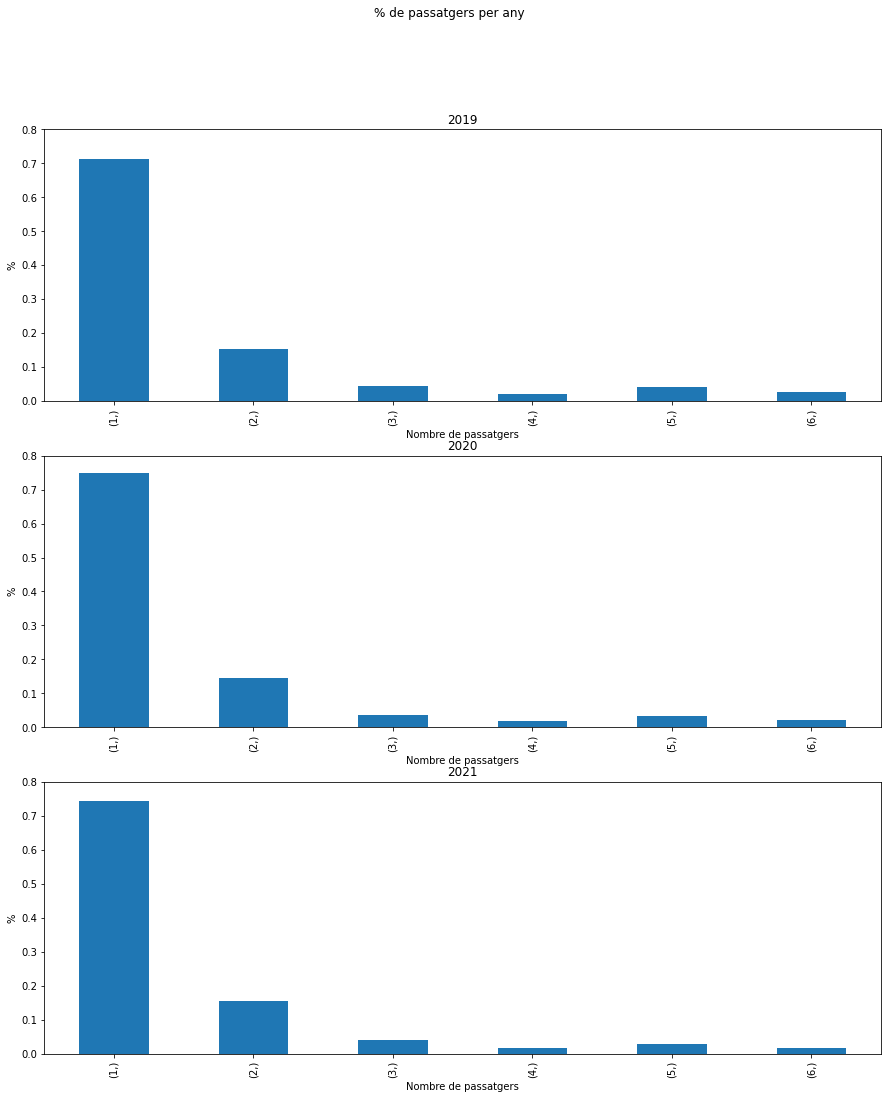

In [22]:
passengers_taxi_year(df, (0, 0.8), 'Nombre de passatgers', '%', '% de passatgers per any', norm = True)

A la figura anterior hem visualitzat cada any per separat. Per tal que la visualització sigui més ràpida i simple d'interpretar, uniu tota la informació en un gràfic.

Després repetiu el mateix gràfic visualitzant el % (utilitzeu el paràmetre *norm*).

In [68]:
def passengers_taxi(df, xlabel, ylabel, norm = False):
    """
    Funció que visualitza quants passatgers hi ha per taxi
    """

        
    # AQUÍ EL TEU CODI
    fig = plt.figure()
    
    X =np.arange(len(df['passenger_count'].unique()))
    w = 0.75/len(YEARS)
    for i in range(len(YEARS)):
        plt.bar(X + w*(i-1), df.loc[df['year']==YEARS[i],['passenger_count']].value_counts(sort=False, normalize=norm), width = w, label=YEARS[i])
    
    plt.xticks(X, sorted(df['passenger_count'].unique()))
    plt.legend()
    plt.show()

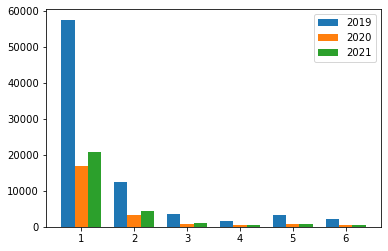

In [69]:
passengers_taxi(df, 'Passenger Count', 'Amount')

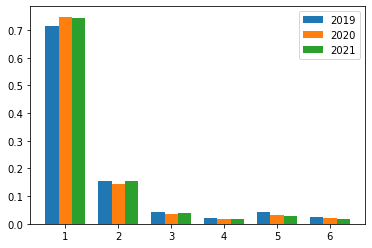

In [70]:
passengers_taxi(df, 'Passenger Count', 'Amount', norm = True)

**Pregunta: Quin impacte heu vist sobre les dades? Creieu que la covid va tenir molt impacte?**

> ANSWER

No sobre la distribució, ja que amb les dades relatives es manté la forma, però sí sobre el nombre de persones, com ja s'havia vist anteriorment

## 03. Quantitat de viatges

Fins ara hem vist la quantitat de viatges que hi ha hagut en els anys estudiats.

Anem a estudiar quins canvis es poden veure si agreguem les dades per hores, dies de la setmana, setmana de l'any i mes.

Aquests gràfics han de ser de línies discontínues i marcar amb una rodona o creu allà on està el valor

In [87]:
def visualize_trips(df, columns, title, xlabel, ylabel):
    """
    Funció que visualitza els viatges per diferents agregacions de dades
    """
    
    # AQUÍ EL TEU CODI
    fig, ax = plt.subplots(1, 2, figsize=(15,6))
    fig.suptitle(title)
    
    for i in range(len(columns)):
        for year in YEARS:
            pd.pivot_table(df[df['year'] == year], values='passenger_count', index=columns[i], aggfunc=np.sum).plot.line(style='.--', ax=ax[i])

        ax[i].legend(YEARS)

        ax[i].set(xlabel=xlabel, ylabel=ylabel)

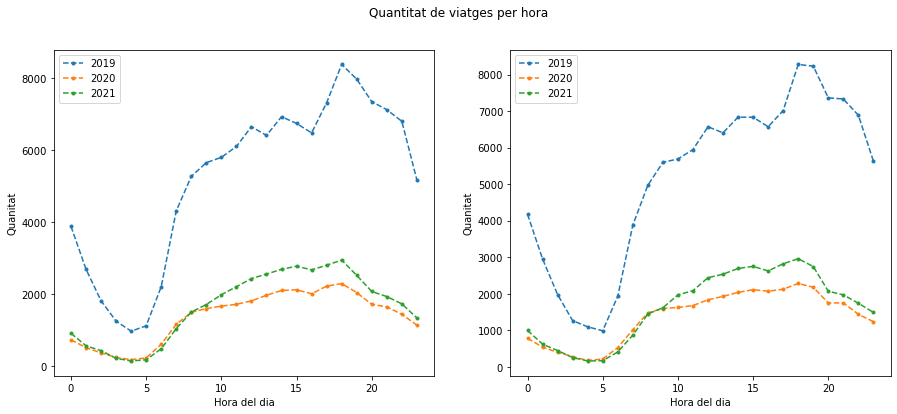

In [119]:
visualize_trips(df, ['pickup_hour', 'dropoff_hour'], title = 'Quantitat de viatges per hora', xlabel = 'Hora del dia', ylabel = 'Quanitat')

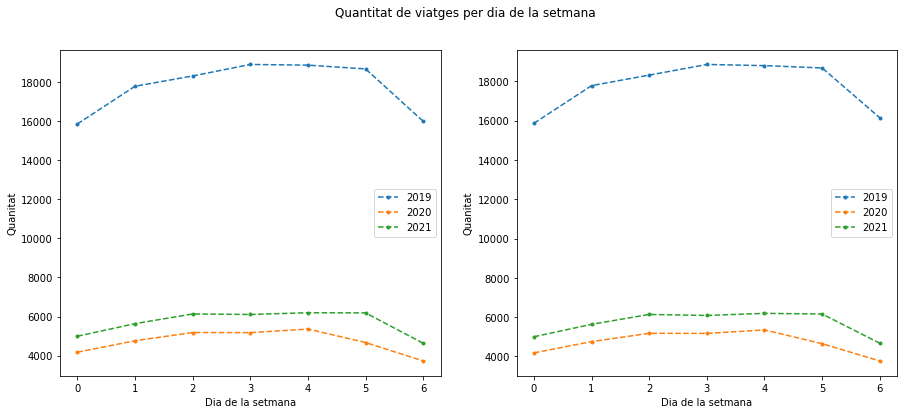

In [120]:
visualize_trips(df, ['pickup_day', 'dropoff_day'], title = 'Quantitat de viatges per dia de la setmana', xlabel = 'Dia de la setmana', ylabel = 'Quanitat')

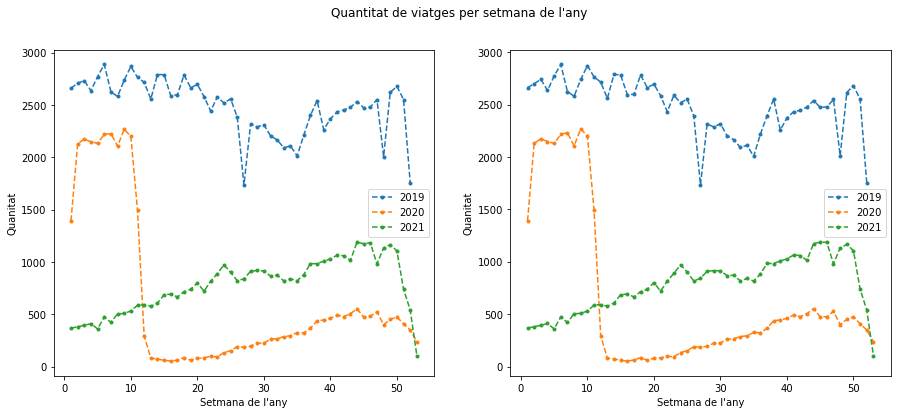

In [233]:
visualize_trips(df, ['pickup_week', 'dropoff_week'], title = 'Quantitat de viatges per setmana de l\'any', xlabel = 'Setmana de l\'any', ylabel = 'Quanitat')

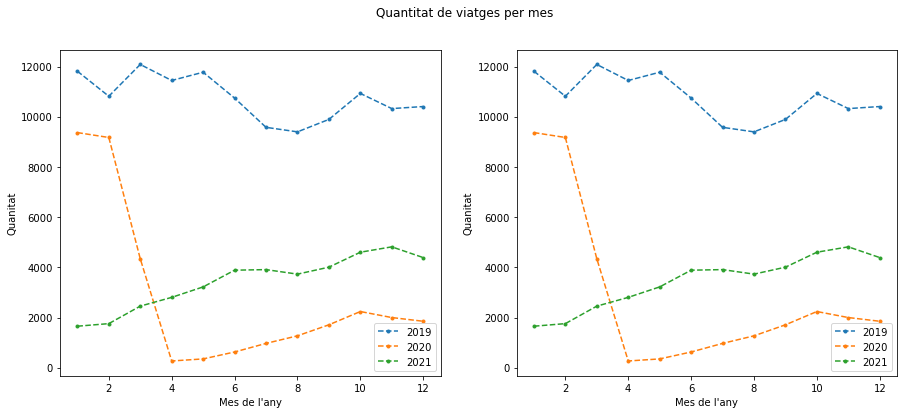

In [232]:
visualize_trips(df, ['pickup_month', 'dropoff_month'], title = 'Quantitat de viatges per mes', xlabel = 'Mes de l\'any', ylabel = 'Quanitat')

**Pregunta: Quins comportaments veieu en cada cas? Quin creieu que és el motiu?**

> ANSWER

## 04. Relació distancia - temps i velocitat

A les dades tenim la distància que ha recorregut el taxi en cada viatge i de la informació temporal podem extreure també la duració d'aquest.


Intentarem esbrinar com la covid va afectar les distàncies i les durades dels viatges juntament amb la velocitat dels taxis.

Creieu que la densitat de trànsit va variar?

### Histogrames

Per començar visualitza els **histogrames** de distància i durada per any.

Pots fer servir la funció *plt.hist()* o *plt.bar()*.

In [77]:

def visualize_histograms(df, column, title, xlabel, ylabel, xlim):
    """
    Funció que crea un histograma a partir de la informació que conté la columna del dataframe
    """
    
    #Crea figura i afegeix títol
    fig, axs = plt.subplots(1, len(YEARS), figsize=(18,5))
    fig.suptitle(title)
    
    #Per cada any fa un histograma amb la columna corresponent
    for i in range(len(YEARS)):
        #Els histogrames tenen contenidors començant al zero i acabant al límit dret. Hi ha uns 50 contenidors
        axs[i].hist(df.loc[df['year']==YEARS[i],column], bins=range(max(0, xlim[0]),xlim[1],max(((xlim[1])//50),1)))
        axs[i].set(xlabel=xlabel, ylabel=ylabel, xlim=xlim, title=YEARS[i])


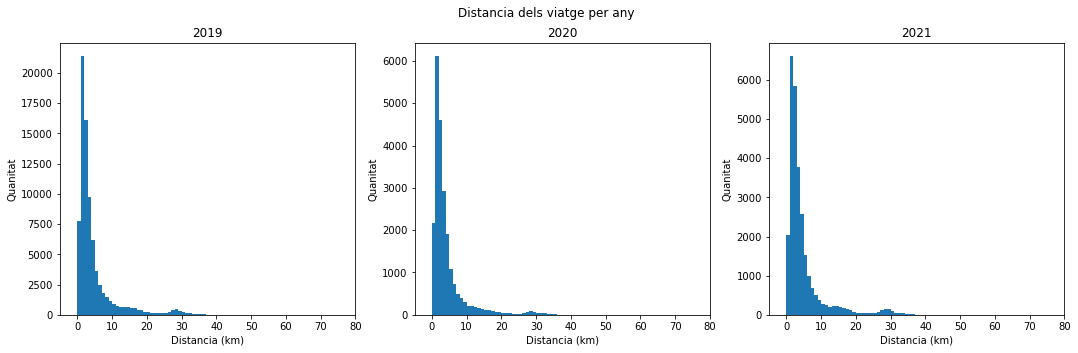

In [78]:
visualize_histograms(df, 'trip_distance', title = 'Distancia dels viatge per any', 
                     xlabel = 'Distancia (km)', ylabel = 'Quanitat', xlim = (-5, 80))
#La mida dels contenidors es d'1 km

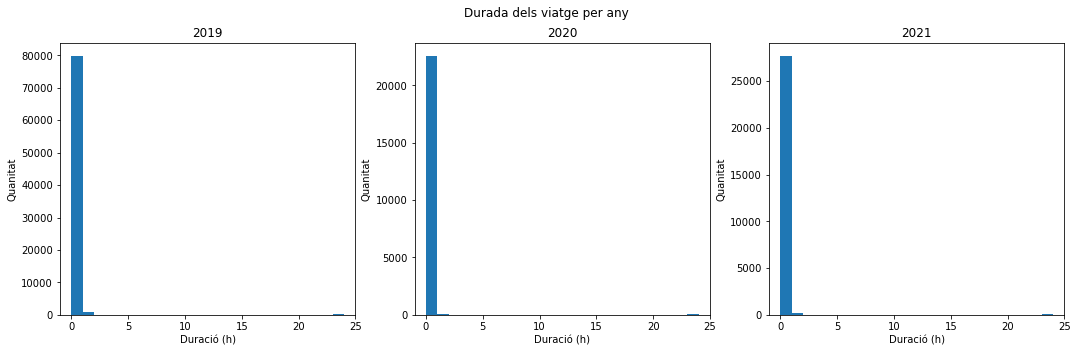

In [72]:
visualize_histograms(df, 'trip_duration', title = 'Durada dels viatge per any', 
                     xlabel = 'Duració (h)', ylabel = 'Quanitat', xlim = (-1, 25) )
#La mida dels contenidors és d'1 hora

**PREGUNTES:** 

* Com creieu que la covid va afectar les distàncies i durades dels viatges?

* I a la velocitat dels taxis?

> ANSWER

In [ ]:
No

### Gràfic de dispersió i correlació

Crea gràfics de dispersió per il·lustrar la relació entre la durada i la distància dels viatges.

Es possible que les dades continguin mostres fora la distribució (outliers). En aquest cas, omet aquestes dades i torna a visualitzar el grafic.

Per veure si existeix alguna correlació, es interesant que utilitzeu la funció *sns.regplot()*.

In [229]:
def scatter_plot(df, x_value, y_value, xlabel, ylabel, remove_outliers = False):
    """
    Funció que mostra un scatter plot donades dues dades
    """
    # AQUÍ EL TEU CODI
    
    ax = sns.regplot(x=x_value, y=y_value, data=df.loc[:, [x_value, y_value]],line_kws={"color": "red"})
    ax.set(xlabel=xlabel, ylabel=ylabel)
    if remove_outliers:
        ax.set_xlim(0, 100)
        ax.set_ylim(0, 4)
    plt.show()

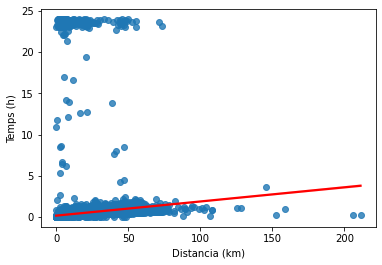

In [227]:
scatter_plot(df, 'trip_distance', 'trip_duration', 'Distancia (km)', 'Temps (h)')

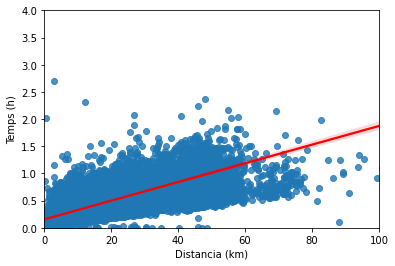

In [230]:
scatter_plot(df, 'trip_distance', 'trip_duration', 'Distancia (km)', 'Temps (h)', True)

**Pregunta: Pots veure alguna relació? Pots calcular la correlació entre les dades per treure més informació?**

> ANSWER

Tal com fèiem a l'apartat 3, visualitzeu les dades temporals i de distància a partir de les setmanes, i mesos de l'any.

In [96]:
def visualize_per_period(df, column_data, columns, xlabel, ylabel, title):
    """
    Funció que visualitza la distància / duració dels trajectes en un temps a determinar
    """
    # AQUÍ EL TEU CODI
    fig, ax = plt.subplots(1, 2, figsize=(15,6))
    fig.suptitle(title)
    
    for i in range(len(columns)):
        for year in YEARS:
            pd.pivot_table(df[df['year'] == year], values=column_data, index=columns[i], aggfunc='mean').plot.line(style='.--', ax=ax[i])

        ax[i].legend(YEARS)

        ax[i].set(xlabel=xlabel, ylabel=ylabel)
    
    
    

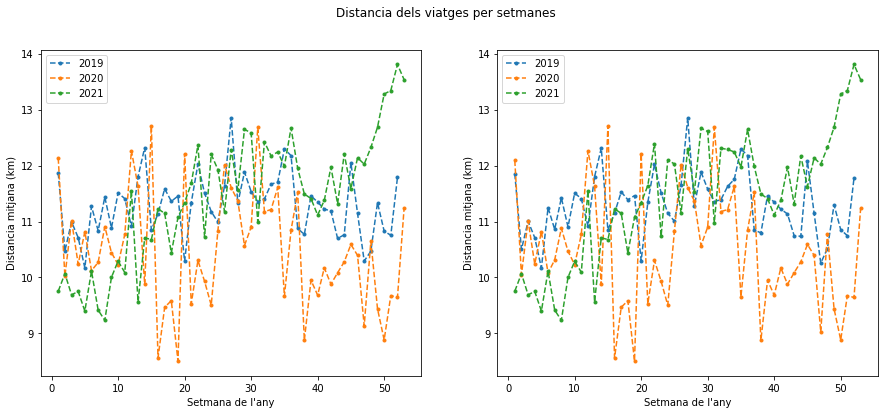

In [123]:
visualize_per_period(df, 'trip_distance', columns = ['pickup_week', 'dropoff_week'],
                    xlabel = 'Setmana de l\'any', ylabel = 'Distancia mitjana (km)', title = 'Distancia dels viatges per setmanes')

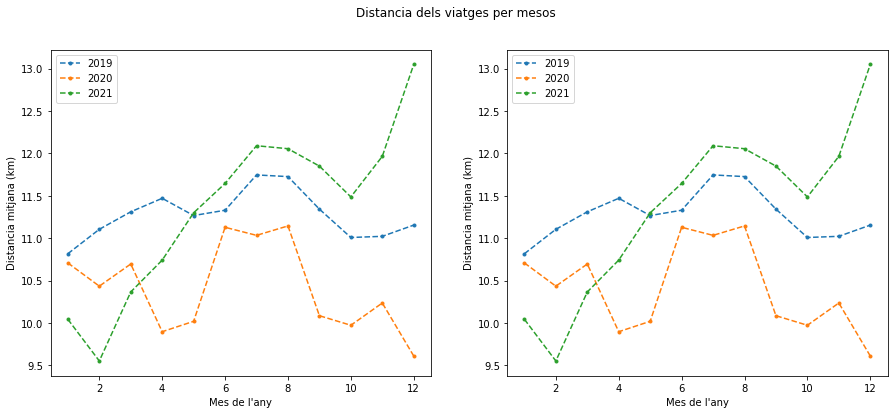

In [124]:
visualize_per_period(df, 'trip_distance', columns = ['pickup_month', 'dropoff_month'],
                     xlabel = 'Mes de l\'any', ylabel = 'Distancia mitjana (km)', title = 'Distancia dels viatges per mesos')

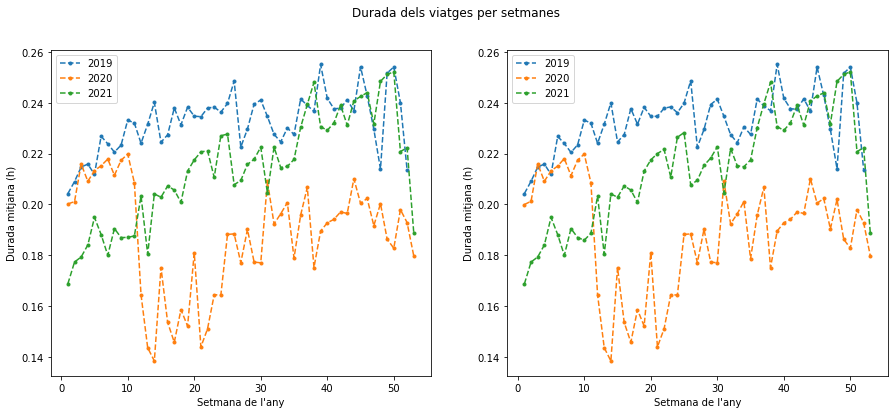

In [125]:
visualize_per_period(df, 'trip_duration', columns = ['pickup_week', 'dropoff_week'],
                     xlabel = 'Setmana de l\'any', ylabel = 'Durada mitjana (h)', title = 'Durada dels viatges per setmanes')

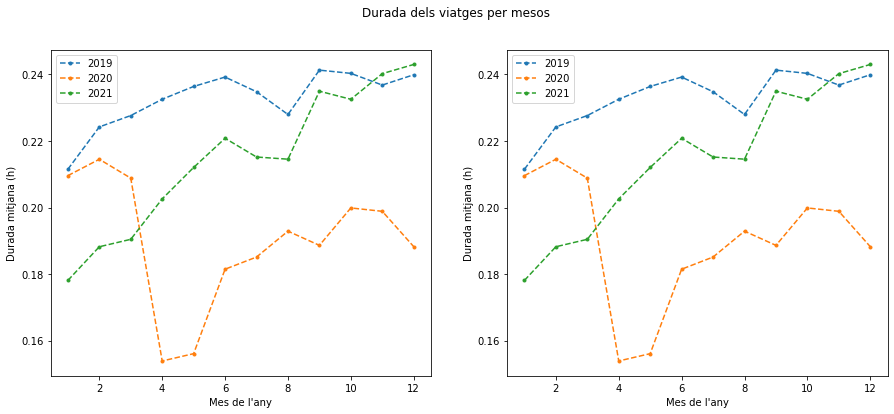

In [126]:
visualize_per_period(df, 'trip_duration', columns = ['pickup_month', 'dropoff_month'],
                     xlabel = 'Mes de l\'any', ylabel = 'Durada mitjana (h)', title = 'Durada dels viatges per mesos')

**Pregunta: Hi ha algun comportament estrany a part de la covid? Per què pot ser causat?**
    
> ANSWER

Fins ara hem mostrat les dades de manera agregada.

Per tal de visualitzar-ho de manera global, utilitzarem la funció *plt.imshow()* que visualitza imatges i, per tant, matrius.

Implementa una funció que visualitzi per any:

- un mapa de calor que indiqui a quina hora del dia hi ha viatges més llargs durant l'any.
- un mapa de calor que indiqui a quina hora del dia hi ha viatges més llargs durant la setmana.

In [178]:
def heatmap(df, group, column_data, xlabel, ylabel, columns = None):
    """
    Funció que agrega les dades de manera adient per visualitzar un mapa de calor
    """
    
    # AQUÍ EL TEU CODI
    fig, ax = plt.subplots(len(YEARS), 1, figsize=(20,6))
    
    for i in range(len(YEARS)):
        matrix = df[df['year']==YEARS[i]].pivot_table(index=group[1],columns=group[0],values=column_data, aggfunc=np.sum, fill_value=0)
        ax[i].imshow(matrix)
        ax[i].set_title(YEARS[i])
        ax[i].set(xlabel=xlabel, ylabel=ylabel)
        if columns !=None:
            ax[i].set_yticks(range(len(columns)))
            ax[i].set_yticklabels(columns)
    plt.tight_layout() 
    plt.show()
    

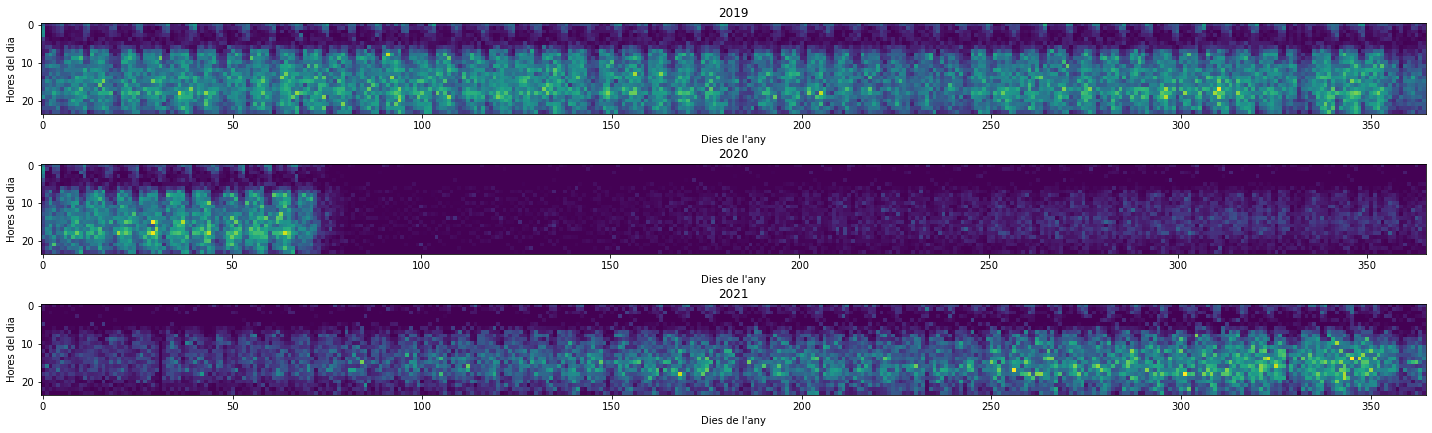

In [179]:
'''DISCLAIMER: hem canviat l\'ordre que ens donava perquè no tenia sentit'''
heatmap(df, ['pickup_dayofyear', 'pickup_hour'], 'trip_duration', 'Dies de l\'any', 'Hores del dia')

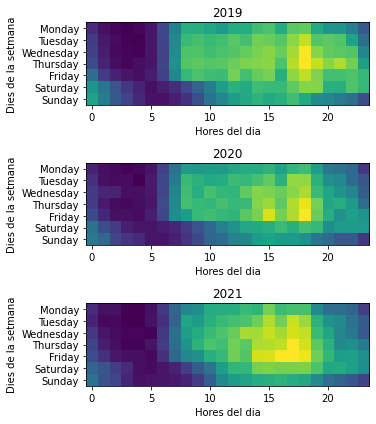

In [180]:
heatmap(df, ['pickup_hour', 'pickup_day'], 'trip_duration', 'Hores del dia', 'Dies de la setmana', ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

Repeteix els gràfics anteriors visualitzant la distancia.

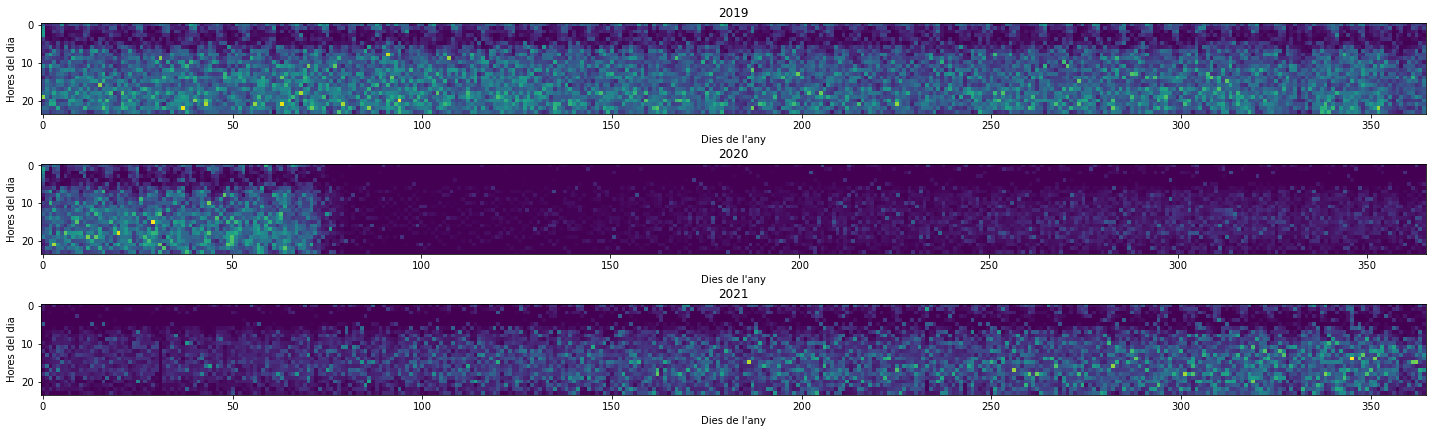

In [181]:
heatmap(df, ['pickup_dayofyear','pickup_hour'], 'trip_distance', 'Dies de l\'any', 'Hores del dia')

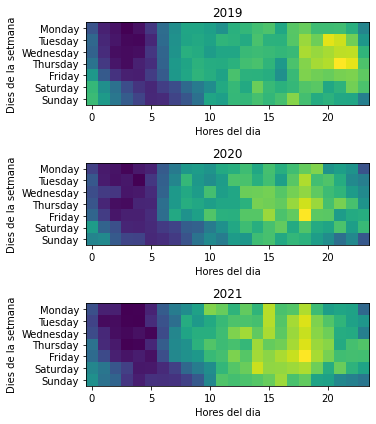

In [182]:
heatmap(df, ['pickup_hour', 'pickup_day'], 'trip_distance', 'Hores del dia', 'Dies de la setmana', ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

Per últim, visualitza la velocitat mitjana a les diferents hores del dia durant la setmana.

In [284]:

def speed_heatmap(df, group, xlabel, ylabel, columns = None):
    """
    Funció que agrega les dades de manera adient per visualitzar la velocitat un mapa de calor
    """
    # AQUÍ EL TEU CODI
    fig, ax = plt.subplots(len(YEARS), 1, figsize=(20,6))
    ms_min = df['mean_speed'].min()
    ms_max = df['mean_speed'].max()
    print(ms_max)
    for i in range(len(YEARS)):
        matrix = df[df['year']==YEARS[i]].pivot_table(index=group[1],columns=group[0],values='mean_speed', aggfunc='mean', fill_value=0)
        clrmap = ax[i].imshow(matrix, vmin=ms_min, vmax=ms_max)
        plt.colorbar(clrmap, ax=ax[i])
        ax[i].set_title(YEARS[i])
        ax[i].set(xlabel=xlabel, ylabel=ylabel)
        if columns != None:
            ax[i].set_yticks(range(len(columns)))
            ax[i].set_yticklabels(columns)

    plt.tight_layout() 
    plt.show()

42762.24


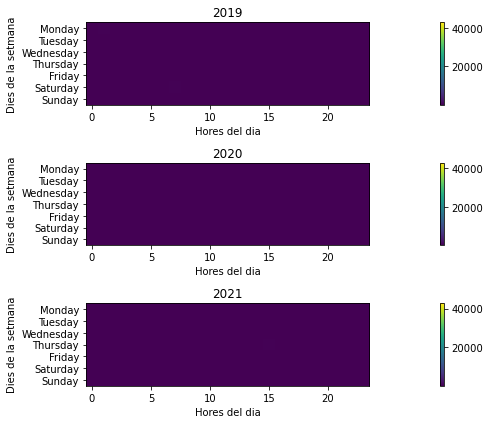

In [285]:
speed_heatmap(df, ['pickup_hour', 'pickup_day'], 'Hores del dia', 'Dies de la setmana', ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

**Pregunta: Quines conclusions treieu dels mapes de calor?**
    
> ANSWER

## 05. Visualitzem les localitzacions dels viatges

In [50]:
df.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount,year,...,dropoff_hour,pickup_day,dropoff_day,pickup_week,dropoff_week,pickup_month,dropoff_month,trip_duration,pickup_dayofyear,mean_speed
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1,2.400,151,239,1,7.0,9.95,2019,...,0,1,1,1,1,1,1,0.111111,1,21.600000
1000,2019-01-01 00:53:09,2019-01-01 01:01:16,1,3.056,148,137,2,8.5,9.80,2019,...,1,1,1,1,1,1,1,0.135278,1,22.590554
3000,2019-01-01 00:54:46,2019-01-01 01:03:13,1,2.240,249,164,1,7.5,11.40,2019,...,1,1,1,1,1,1,1,0.140833,1,15.905325
4000,2019-01-01 00:09:29,2019-01-01 00:12:29,2,1.072,162,137,2,4.0,5.30,2019,...,0,1,1,1,1,1,1,0.050000,1,21.440000
5000,2019-01-01 00:29:00,2019-01-01 00:46:19,1,4.336,161,262,1,13.5,17.76,2019,...,0,1,1,1,1,1,1,0.288611,1,15.023677


Només tenim la ID d'una localització, per tant, necessitem aconseguir la latitud i la longitud.

La mateixa pàgina dels taxis ens dóna el fitxer *taxi_zones.zip*, però primer cal que convertim les dades de coordenades amb format WGS84.

Podem utilitzar aquesta web: https://mygeodata.cloud/

In [51]:
from utils import get_lat_lon, draw_region_map, draw_zone_map

In [52]:
sf = shapefile.Reader('data/geodata/taxi_zones.shp')

fields_name = [field[0] for field in sf.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

In [53]:
df_loc = pd.DataFrame(shp_attr).join(get_lat_lon(sf, shp_dic).set_index("LocationID"), on="LocationID")
df_loc.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,longitude,latitude
0,1,0.116357,0.000782,Newark Airport,1,EWR,-74.171533,40.689483
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,-73.822478,40.610824
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,-73.844953,40.865747
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,-73.977725,40.724137
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,-74.187558,40.550664


In [54]:
#Es pot veure que hi ha locationID's repetides. S'haurà de tractar
df_loc.iloc[54:60]

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,longitude,latitude
54,55,0.149957,0.000736,Coney Island,55,Brooklyn,-73.986212,40.577087
55,56,0.056848,0.000181,Corona,56,Queens,-73.857709,40.741567
55,56,0.056848,0.000181,Corona,56,Queens,-73.853350,40.751981
56,57,0.019271,0.000018,Corona,56,Queens,-73.857709,40.741567
56,57,0.019271,0.000018,Corona,56,Queens,-73.853350,40.751981
57,58,0.059855,0.000205,Country Club,58,Bronx,-73.818971,40.841495


In [55]:
df_loc['LocationID'].unique() #Mostra tots els possibles valors per LocationID
#el nostre dataframe principal ja està netejat per tant, en principi, només conté aquestes locationID

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 106, 107,
       108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
       121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
       134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146,
       147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159,
       160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172,
       173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 18

D:\Anaconda\lib\site-packages\descartes\patch.py:63: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  concatenate([asarray(t.exterior)[:, :2]] +


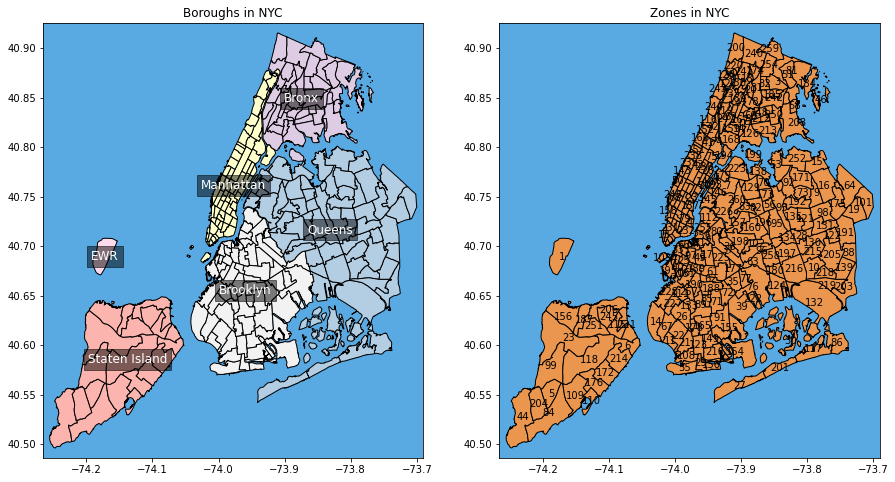

In [56]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Boroughs in NYC")
draw_region_map(ax, sf, shp_dic)
ax = plt.subplot(1, 2, 2)
ax.set_title("Zones in NYC")
draw_zone_map(ax, sf, shp_dic)

Ara teniu dos dataframe que necessitem unir. Utilitza la funció *merge* per afegir la longitud i latitud al dataframe *df*:

In [57]:
'''
Afegim 4 columnes al dataframe df: latitud_PU, longitud_PU, latitud_DO i longitud_DO
'''
def merge_locations(df, df_loc, left_on, suffix):
    '''Funció que fa el left merge de dos dataframes segons la clau "left_on" per la dataframe de l`esquerra
    i que afegeix a les noves columnes el sufix "suffix".
    Pren 2 dataframes, i 2 strings com a paràmetres
    Retorna un nou dataframe'''
    #Utilitza la funció merge de pandas per fer el left join dels dos dataframes amb la informació que volem
    merge = pd.merge(df, df_loc[['LocationID', 'longitude', 'latitude']], how="left", left_on=left_on, right_on='LocationID')
    #Canvia el nom de les columnes afegint un sufix que es passa per paràmetre per diferenciar-les
    merge.rename(columns={'longitude' : 'longitude'+suffix, 'latitude' : 'latitude'+suffix}, inplace = True)
    #eliminem la columna de locationID, doncs seria duplicada
    merge.drop('LocationID', axis='columns', inplace=True)
    return merge
#Utilitza la funció que hem definit per tal de fer el merge 2 cops. Un per DO i l'altre per PU
merge = merge_locations(merge_locations(df, df_loc, 'PULocationID', '_PU'), df_loc, 'DOLocationID', '_DO')
merge.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,PULocationID,DOLocationID,payment_type,fare_amount,total_amount,year,...,dropoff_week,pickup_month,dropoff_month,trip_duration,pickup_dayofyear,mean_speed,longitude_PU,latitude_PU,longitude_DO,latitude_DO
0,2019-01-01 00:46:40,2019-01-01 00:53:20,1,2.400,151,239,1,7.0,9.95,2019,...,1,1,1,0.111111,1,21.600000,-73.968222,40.797859,-73.978732,40.784025
1,2019-01-01 00:53:09,2019-01-01 01:01:16,1,3.056,148,137,2,8.5,9.80,2019,...,1,1,1,0.135278,1,22.590554,-73.990664,40.719102,-73.977172,40.740336
2,2019-01-01 00:54:46,2019-01-01 01:03:13,1,2.240,249,164,1,7.5,11.40,2019,...,1,1,1,0.140833,1,15.905325,-74.001965,40.734611,-73.985684,40.749083
3,2019-01-01 00:09:29,2019-01-01 00:12:29,2,1.072,162,137,2,4.0,5.30,2019,...,1,1,1,0.050000,1,21.440000,-73.972471,40.756840,-73.977172,40.740336
4,2019-01-01 00:29:00,2019-01-01 00:46:19,1,4.336,161,262,1,13.5,17.76,2019,...,1,1,1,0.288611,1,15.023677,-73.977680,40.758030,-73.945142,40.776681


In [58]:
#Comprovem que no són iguals. Això es deu a que no hem gestionat que hi hagi locationID's repetides a df_loc
print(df.shape, merge.shape)

(131376, 21) (131559, 25)


## 06. ¿Quines zones tenen més recollides i quines zones tenen més entregues?

En aquest apartat volem conèixer i visualitzar les zones on els taxis són més utilitzats.

El primer pas és ordenar i guardar en una variable els llocs més comuns en la recollida i el destí.

Printa els 5 llocs més freqüents per any en cada cas.

In [59]:
# Recollida
# AQUÍ EL TEU CODI
top_pu = merge.groupby(['year','PULocationID']).count().sort_values(['year', 'trip_distance'], ascending = False)['trip_distance'].reset_index()


top_pu = merge['PULocationID'].value_counts().to_frame() #ja s'ordena de més a menys
top_pu.rename(columns={'PULocationID':'n_trips'}, inplace=True)

# Destí
# AQUÍ EL TEU CODI
top_do = merge['DOLocationID'].value_counts().to_frame() #ja s'ordena de més a menys
top_do.rename(columns={'DOLocationID':'n_trips'}, inplace=True)

In [60]:
n_top = 5
def show_top_n(df, column, df_loc, n_top = n_top):
    """
    Funció que mostra els llocs més usuals per any
    """
    # AQUÍ EL TEU CODI
    for year in YEARS:
        print(year)
        print(df[0:n_top].index.to_list())

In [61]:
show_top_n(top_pu, 'PULocationID', df_loc)

2019
[237, 236, 161, 186, 162]
2020
[237, 236, 161, 186, 162]
2021
[237, 236, 161, 186, 162]


In [62]:
show_top_n(top_do, 'DOLocationID', df_loc)

2019
[236, 237, 161, 170, 162]
2020
[236, 237, 161, 170, 162]
2021
[236, 237, 161, 170, 162]


**Visualitzem amb un mapa de calor quines són les zones més recurrents**

In [63]:
for year in YEARS:
    PUcount = {k:v for k, v in top_do[top_do.year == year][['DOLocationID', 'trip_distance']].values}

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    ax = plt.subplot(1, 2, 1)
    ax.set_title(f"Zones with most pickups - {year}")
    draw_zone_map(ax, sf, shp_dic, heat=PUcount, text=list(PUcount.keys())[:3])
    ax = plt.subplot(1, 2, 2)
    ax.set_title(f"Zones with most drop-offs - {year}")
    draw_zone_map(ax, sf, shp_dic, heat=PUcount, text=list(PUcount.keys())[:3])

AttributeError: 'DataFrame' object has no attribute 'year'

**Pregunta: Per què creieu que la zona de Manhattan té més quantitat de viatges?**
> ANSWER

## 07. Hospitals

Com ha canviat la destinació dels viatges? Hi ha més gent que va als hospitals?

A la següent cel·la us donem la creació manual d'un DataFrame amb la localització més important dels hospitals de Nova York.

In [64]:
hospitals = [('New York’s Presbyterian Lower Manhattan Hospital, NYC, NY, USA', '40.710255', '-74.005058'),
('Manhattan Gastroenterology, NYC, NY, USA', '40.778259', '-73.958092'),
('Stem Cell Therapy Hospital, NYC, NY, USA', '40.601517', '-73.961067'),
('Park Avenue Smiles, Yonkers, NYC, NY, USA', '40.945873', '-73.890671'),
('Cosmetic Dentistry Center, NYC, NY, USA', '40.629234', '-74.026077'),
('Envy Smile Dental Spa, Brooklyn, NYC, NY, USA', '40.607059', '-73.960144'),
('VIVA EVE, Forest Hills, NYC, NY, USA', '40.734291', '-73.849434'),
('Forest Hills Medical Services, Queens, NYC, NY, USA', '40.734310', '-73.849510'),
('Professional Gynecological Services, Brooklyn, NY, NY, USA', '40.689747', '-73.982346'),
('Manhattan Womens Health & Wellness, New York, NY, USA', '40.741997', '-73.986107'),
('Brooklyn Abortion Clinic, Brooklyn, NY, New York, USA', '40.689743', '-73.982368'),
('Brooklyn GYN Place, Brooklyn, NY, USA', '40.692696', '-73.993584'),
('Americas Holistic Doctor, NYC, NY, USA', '40.742531', '-73.985489'),
('NJS Physical Medicine & Rehabilitation, Brooklyn, NY, USA', '40.641621', '-73.956734'),
('DHD Medical, Brooklyn New York, USA', '40.625568', '-73.918320'),
('Workers Compensation Doctor, New York, NY, USA', '40.652225', '-74.006104'),]

hospitals = pd.DataFrame(hospitals, columns = ['Place Name', 'Latitude', 'Longitude'])
hospitals['Latitude'] = hospitals['Latitude'].astype(float)
hospitals['Longitude'] = hospitals['Longitude'].astype(float)
hospitals.head()

,Place Name,Latitude,Longitude
0,New York’s Presbyterian Lower Manhattan Hospit...,40.710255,-74.005058
1,"Manhattan Gastroenterology, NYC, NY, USA",40.778259,-73.958092
2,"Stem Cell Therapy Hospital, NYC, NY, USA",40.601517,-73.961067
3,"Park Avenue Smiles, Yonkers, NYC, NY, USA",40.945873,-73.890671
4,"Cosmetic Dentistry Center, NYC, NY, USA",40.629234,-74.026077


Utilitza la latitud i longitud de cada hospital i la de les zones del dataframe *merge* per veure la distribució dels hospitals.

Per fer-ho utilitza els gràfics de dispersió. Recorda que s'entendrà millor si els punts són transparents (paràmetre *alpha*).

Després repeteix el mateix gràfic però separat per any. 

In [65]:
def scatter_locations(merge, hospitals):
    """Funció que mostra la distribució dels hospitals i les destinacions dels taxis"""
    #Crea una figura on hi dubuixa els punts dels coordenades dels hospitals i les de les localitzacions de dropoff (destinacions)
    fig, ax = plt.subplots(figsize=(15,7))
    merge.plot.scatter(x='longitude_DO', y='latitude_DO', alpha=0.1, ax=ax, color='blue')
    hospitals.plot.scatter(x='Longitude', y='Latitude', alpha=0.5, ax=ax, color='red')

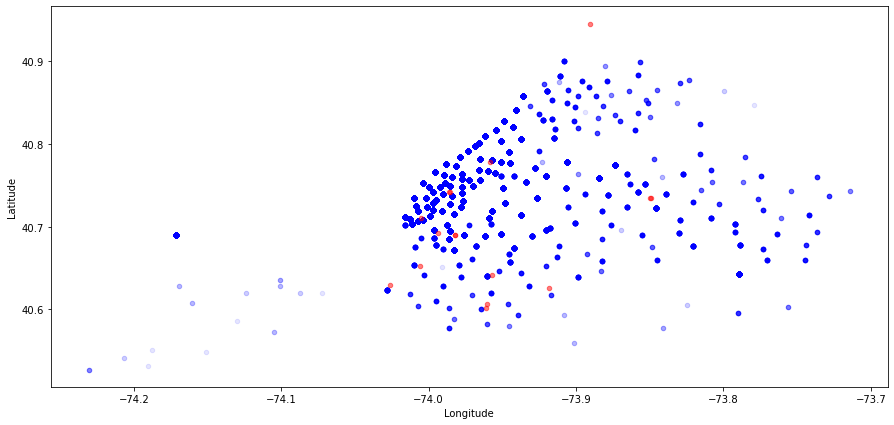

In [66]:
scatter_locations(merge, hospitals)

In [67]:
def scatter_locations_per_year(merge, hospitals):
    """Funció que mostra la distribució dels hospitals i les destinacions dels taxis"""
    # Per cada un dels anys que estem estudiant dibuixem un gràfic com l'anterior
    for year in YEARS:
        fig, ax = plt.subplots(figsize=(15,7))
        merge.loc[merge['year']==year,:].plot.scatter(x='longitude_DO', y='latitude_DO', alpha=0.1, ax=ax, cmap='viridis')
        hospitals.plot.scatter(x='Longitude', y='Latitude', alpha=0.5, ax=ax, color='red')
        fig.suptitle('Any: '+str(year), fontweight='bold')

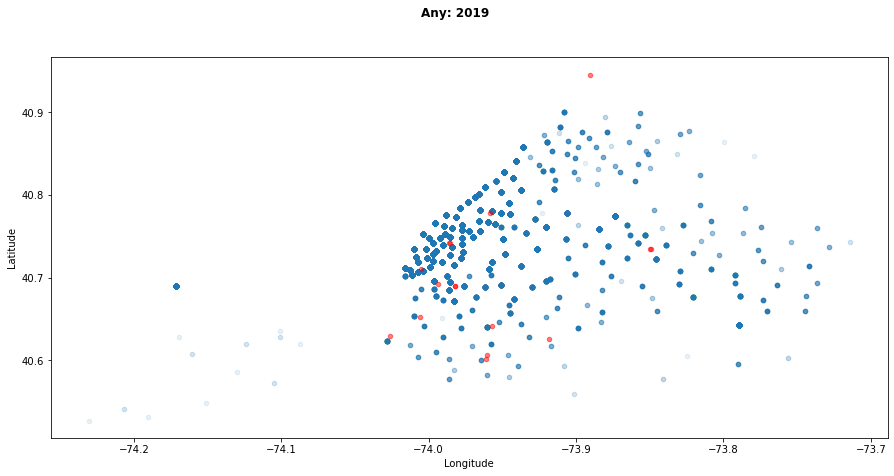

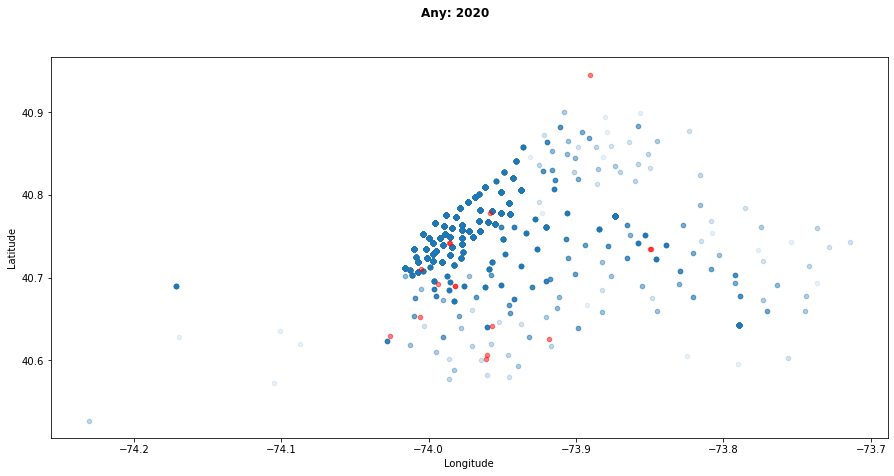

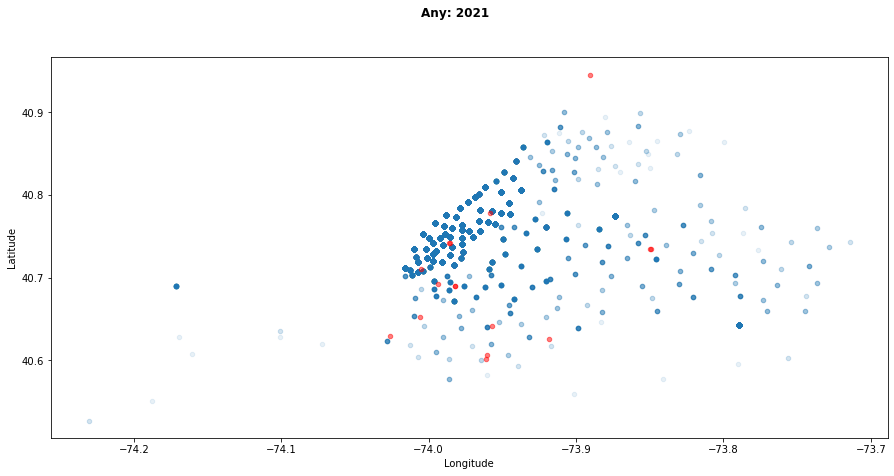

In [68]:
scatter_locations_per_year(merge, hospitals)

**Pregunta: Veus algun comportament?**
>ANSWER

In [69]:
'''Es pot observar com no sembla que hi hagi cap tipus de relació. Com sembla lògic pensar, la gent no agafa el taxi per anar
als hospitals amb una freqüència prou gran com per establir una relació. Tanmateix, es pot tornar a observar com en els anys
de COVID la  distribució de viatges és encara més centrada en Manhattan, havent-hi molts menys viatges a zones menys 
populars de la ciutat.'''

'Es pot observar com no sembla que hi hagi cap tipus de relació. Com sembla lògic pensar, la gent no agafa el taxi per anar\nals hospitals amb una freqüència prou gran com per establir una relació. Tanmateix, es pot tornar a observar com en els anys\nde COVID la  distribució de viatges és encara més centrada en Manhattan, havent-hi molts menys viatges a zones menys \npopulars de la ciutat.'

Per poder conèixer com ha variat els trajectes als hospitals, primer cal detectar a quina localització del mapa pertany cada hospital.

Per fer això cal calcular les distàncies. No calculeu la distància punt a punt, sinó matricialment.

In [70]:
from scipy.spatial import distance_matrix

In [71]:
hospitals_loc = hospitals[['Longitude', 'Latitude']].values
loc = df_loc[['longitude', 'latitude']].values

# Creem una matriu de distàncies entre la localització dels hospitals i les posicions de destí dels taxis
dist = distance_matrix(hospitals_loc, loc)

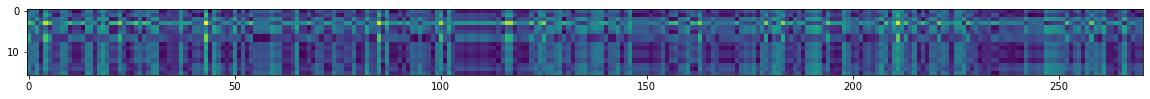

In [72]:
plt.figure(figsize=(20, 5))
plt.imshow(dist)

Trobeu la manera de localitzar el sector més proper a partir de les distàncies.

In [73]:
# Prenem com a localització dels hospitals aquella zona que tingui una distància menor amb les coordenades de l'hospital
hospitals_locations = dist.argmin(axis=1)
#Afegeix una columna amb la id de localització a la taula dels hospitals
hospitals['LocationID'] = hospitals_locations + 1 #sumem 1 perque les columnes van de 0 a 262 i volem que correpongui amb les loc id

In [74]:
hospitals.head()

,Place Name,Latitude,Longitude,LocationID
0,New York’s Presbyterian Lower Manhattan Hospit...,40.710255,-74.005058,217
1,"Manhattan Gastroenterology, NYC, NY, USA",40.778259,-73.958092,244
2,"Stem Cell Therapy Hospital, NYC, NY, USA",40.601517,-73.961067,131
3,"Park Avenue Smiles, Yonkers, NYC, NY, USA",40.945873,-73.890671,208
4,"Cosmetic Dentistry Center, NYC, NY, USA",40.629234,-74.026077,14


Ara que ja tenim en quin sector es troben els hospitals, visualitzeu quants trajectes hi ha relacionats amb ells.

Suposarem que tots els trajectes al sector van a l'hospital.

Feu una única figura amb dos gràfics de barres on es mostrin la quantitat de viatges per cada any i el % del total dels viatges.

In [75]:
def trips_hospitals(df, hospitals_locations):
    """
    Funció que mostra una única figura amb dos gràfics de barres on es mostrin la quantitat de viatges per cada any i el % del total dels viatges.
    """
    # AQUÍ EL TEU CODI
    

In [76]:
trips_hospitals(df, hospitals_locations)

## 08. Qui escolta pels forats, sent els seus pecats

A la **primera part** heu de visualitzar i comentar els exemples que hem eliminat, com distancies molt llargues, molt curtes...

A la **segona part** teniu llibertat per escollir i fer visualitzacions que us aportin informació extra que no s'hagi vist anteriorment.

In [ ]:
'''
Viatges als aeroports
relacio distancia/preu
payment type
'''

### Viatges als aeroports
En aquest apartat continuem estudiant si ha canviat la destinació dels passatgers. En concret, mirarem si els viatges a l'aeroport han disminuit en relació a la resta de viatges.

In [231]:
airports = [('John F. Kennedy International Airport', 'JFK', '40.641766', '-73.780968'),
('Newark Liberty International Airport', 'EWR', '40.689531', '-74.174462'),
('LaGuardia Airport', 'LGA', '40.776927', '-73.873966'),
('Long Island MacArthur Airport', 'ISP', '40.789845', '-73.097568'),
('Stewart International Airport', 'SWF', '41.498403', '-74.100863'),
('Trenton–Mercer Airport', 'TTN', '40.276999', '-74.817951'),
('Westchester County Airport', 'HPN', '41.068333', '-73.708664'),]

airports = pd.DataFrame(airports, columns = ['Place Name', 'IATA', 'Latitude', 'Longitude'])
airports['Latitude'] = airports['Latitude'].astype(float)
airports['Longitude'] = airports['Longitude'].astype(float)
airports.head()

,Place Name,IATA,Latitude,Longitude
0,John F. Kennedy International Airport,JFK,40.641766,-73.780968
1,Newark Liberty International Airport,EWR,40.689531,-74.174462
2,LaGuardia Airport,LGA,40.776927,-73.873966
3,Long Island MacArthur Airport,ISP,40.789845,-73.097568
4,Stewart International Airport,SWF,41.498403,-74.100863


### Tipus de pagament
En aquest apartat estudiarem si la COVID va causar un canvi en la preferència de tipus de pagament. Els passatgers han començat a pagar més amb targeta?

## 09. Informe

A partir de l'exploració de les dades que heu fet al llarg d'aquest notebook, feu un petit informe resumint i justificant tots els canvis que han sorgit a causa de la covid.